In [1]:
import json
import sys
import os
_ROOT_PATH = "/home/jiangpeiwen2/jiangpeiwen2/text-kgs-table/"
sys.path.append(_ROOT_PATH)
from components.kgs.dataset_kgs.e2e_rotowire_field import fields_list_rotowire, fields_list_e2e
from components.kgs.dataset_kgs.CPL_field import fields_list_CPL
from libs import read_hot_words, chat_LLM, _ROOT_PATH, _DATA_PATH, data_list, role_info_extra_prompt, role_types_extra_prompts, event_role_relation_request, Entity_KGs_construction_request

In [2]:
# 词频统计结果加载
_e2e_words_freq = read_hot_words( 0 )
_rotowire_words_freq = read_hot_words( 1 )
_wikitabletext_words_freq = read_hot_words( 2 )
_CPL_words_freq = read_hot_words( 3 )
_wikibio_words_freq = read_hot_words( 4 )
fre_list = [_e2e_words_freq, _rotowire_words_freq, _wikitabletext_words_freq, _wikibio_words_freq, _CPL_words_freq]

{'Total words': 1152364, 'Lines': 51426, 'Average_words_Line': 22.408198187687162, 'Total words after filter': 565068}
{'Total words': 1637820, 'Lines': 4853, 'Average_words_Line': 337.4860910776839, 'Total words after filter': 654614}
{'Total words': 185111, 'Lines': 13318, 'Average_words_Line': 13.899309205586425, 'Total words after filter': 92634}
{'Total words': 70257683, 'Lines': 728221, 'Average_words_Line': 96.47851819708578, 'Total words after filter': 31768599}


# 大模型生成知识图谱类的质量评估方法（知识图谱的类而非实例）
## 1.基于辅助人类构建领域知识图谱这一目的，而非直接生成领域知识图谱
## 2.指定得分标准，人类进行评价
## 3.评分标准如下：对目标数据集由人指定字段集合，遍历生成的字段逐个与目标字段进行匹配，总分为1，所有字段平分得分（也可根据重要性）
（1）完全匹配Totally Match：生成的字段中有至少一个字段和目标中的某个字段在形式或语义上完全匹配，则获得该目标字段的总分。但只有一个计分。
（2）包含匹配Including：生成的字段中有至少一个是目标字段中某个或某些字段的邻近父概念（邻近指可以通过后续原文信息自然推断出子概念），则获得所有目标字段之和的75%
（3）被包含匹配Included：生成的字段中至少一个是某个目标字段的子概念。若父概念有限可分，则获得字段分数/类别数（如目标字段是双亲，预测父亲，则获得1/2的分数，不同的子概念可叠加，如预测除了父亲和母亲，则获得全部）；若父概念不可分，则获得25%
（4）不匹配Not Match：预测字段中没有和目标字段相关的，如汽车和狗。
在预测的字段中找目标字段的匹配结果，累计得分


# e2e, role info extract
## 目标是七个字段：Name, Price range, Customer rating, Near, Food, Area, Family friendly。1/7
### 直接提示词
3.5/7
### 无词频提示：Name, Location, Cuisine, Menu Offerings, Price Range, Rating, Reviews, Ambiance, Service Style, Hours of Operation, Reservations, Awards and Recognition.
1/7( 1+0.75+1+1+1+0.75+0) = 5.5/7
### 有词频提示:Name, Cuisine Type, Average Price Range, Location, Rating, Food Quality, Service Style (e.g. family-friendly, pub), Menu Options, Ambiance (e.g. riverside, city centre), Specialties (e.g. Italian, Indian), Coffee/Bar Options, and Overall Atmosphere
1/7( 1+1+1+1+1+1+0.75) = 6.75/7

'''


In [11]:
ordinary_truth = "User comments datas about a restaurant in several aspects."
statistic_words = fre_list[0]

e2e_no_statistic_inputs = role_info_extra_prompt.format( ROLE="A restaurant", DESC=ordinary_truth, WORDS="No related words")
e2e_statistic_inputs = role_info_extra_prompt.format( ROLE="A restaurant", DESC=ordinary_truth, WORDS=statistic_words)
response_e2e_0 = chat_LLM(e2e_no_statistic_inputs)
response_e2e_1 = chat_LLM(e2e_statistic_inputs)

Based on the description and high-frequency words provided, I will infer the properties of the role type "A restaurant".

Since there are no high-frequency words provided, I will rely on my general knowledge of restaurants and common attributes associated with them.

Here is my response:

Name, Address, Cuisine Type, Menu Offerings, Price Range, Ambiance, Reviews, Rating, Hours of Operation, Reservations, Parking Availability, Delivery Options.

Please let me know if this is accurate or if you'd like me to revise anything!
Based on the description and high-frequency words provided, I infer that the properties of a restaurant role type are:

Name, Cuisine Type, Average Price Range, Location, Rating, Ambience, Family Friendliness, Menu Options, Specialty Dishes, Coffee Options, Nearby Landmarks, City Centre Distance, Riverside View, Pub Facilities, Indian/Italian/Café Options, Customer Reviews.

Please let me know if this is accurate or if I need to make any adjustments!


In [2]:
response_e2e_2 = chat_LLM( "Please list the property of restaurant according to "+"User comments datas about a restaurant in several aspects.")

Here are some common properties of a restaurant that can be inferred from user comments data in several aspects:

**Food**

* Taste: delicious, bland, spicy, sweet, etc.
* Quality: fresh, stale, overcooked, undercooked, etc.
* Variety: diverse options, limited options, unique dishes, etc.
* Portion size: large, small, just right, etc.
* Price: affordable, expensive, value for money, etc.

**Service**

* Friendliness: friendly, unfriendly, attentive, inattentive, etc.
* Responsiveness: quick, slow, responsive, unresponsive, etc.
* Knowledge: knowledgeable, unknowledgeable, helpful, unhelpful, etc.
* Attitude: welcoming, unwelcoming, patient, impatient, etc.

**Ambiance**

* Atmosphere: cozy, loud, romantic, family-friendly, etc.
* Decor: modern, traditional, elegant, casual, etc.
* Cleanliness: clean, dirty, well-maintained, poorly maintained, etc.
* Comfort: comfortable, uncomfortable, spacious, cramped, etc.

**Value**

* Price-to-quality ratio: good value, bad value, overpriced, unde

# rotowire, role completion and info extract
## 目标是13 + 20
### 直接
（1）球队
1. **Points**: Total points scored by a team in a game.
2. **Field Goals Made (FGM)**: Number of field goals made by a team in a game.
3. **Field Goals Attempted (FGA)**: Number of field goals attempted by a team in a game.
4. **Field Goal Percentage (FG%)**: Percentage of field goals made by a team in a game.
5. **Three-Pointers Made (3PM)**: Number of three-pointers made by a team in a game.
6. **Three-Pointers Attempted (3PA)**: Number of three-pointers attempted by a team in a game.
7. **Three-Point Percentage (3P%)**: Percentage of three-pointers made by a team in a game.
8. **Free Throws Made (FTM)**: Number of free throws made by a team in a game.
9. **Free Throws Attempted (FTA)**: Number of free throws attempted by a team in a game.
10. **Free Throw Percentage (FT%)**: Percentage of free throws made by a team in a game.
11. **Rebounds**: Total rebounds grabbed by a team in a game.
12. **Assists**: Total assists made by a team in a game.
13. **Steals**: Total steals made by a team in a game.
14. **Blocks**: Total blocks made by a team in a game.
15. **Turnovers**: Total turnovers committed by a team in a game.

**Player Properties:**

1. **Points**: Total points scored by a player in a game.
2. **Field Goals Made (FGM)**: Number of field goals made by a player in a game.
3. **Field Goals Attempted (FGA)**: Number of field goals attempted by a player in a game.
4. **Field Goal Percentage (FG%)**: Percentage of field goals made by a player in a game.
5. **Three-Pointers Made (3PM)**: Number of three-pointers made by a player in a game.
6. **Three-Pointers Attempted (3PA)**: Number of three-pointers attempted by a player in a game.
7. **Three-Point Percentage (3P%)**: Percentage of three-pointers made by a player in a game.
8. **Free Throws Made (FTM)**: Number of free throws made by a player in a game.
9. **Free Throws Attempted (FTA)**: Number of free throws attempted by a player in a game.
10. **Free Throw Percentage (FT%)**: Percentage of free throws made by a player in a game.
11. **Rebounds**: Total rebounds grabbed by a player in a game.
12. **Assists**: Total assists made by a player in a game.
13. **Steals**: Total steals made by a player in a game.
14. **Blocks**: Total blocks made by a player in a game.
15. **Turnovers**: Total turnovers committed by a player in a game.
16. **Minutes Played**: Total minutes played by a player in a game.
17. **Plus/Minus**: The point differential when a player is on the court.

9/13
16/20

### 无词频提示：
（1）球队：*Name*, Arena, Location, Conference, Division, Founded, Team Value, Owner, Head Coach, Assistant Coaches, Roster, Players, Positions, Games Played, *Wins*, *Losses*, *Points Scored*, Points Allowed, *Rebounds*, *Assists*, *Steals*, *Blocks*, *Turnovers*, *Field Goal Percentage*, *Three-Point Shooting Percentage*, *Free Throw Percentage*.
（2）球员：*Name*, Team, Position, Height, Weight, College, NBA Debut, *Points Per Game*, *Rebounds Per Game*, *Assists Per Game*, *Blocks Per Game*, *Steals Per Game*, *Shooting Percentage*, Career Awards, Career Highlights.

(1+1+1+1+1+1+1+1+1+4*0.75)/13=12/13
(6+2*0.75 + 6*0.75)/20 = 12/20

### 有词频提示:
（1）球队：1. *Team Name*
2. *Points Scored*
3. *Rebounds*
4. *Assists*
5. Minutes Played
6. *Field Goal Percentage*
7. *Three-Point Shooting Percentage*
8. Free Throw Percentage
9. Steals
10. Blocks
11. *Turnovers*
12. *Wins*
13. *Losses*
14. Home Record
15. Away Record
16. Conference
17. Division
18. Starting Lineup
19. Bench Strength
20. Season Performance
（2）球员：
*Name*, *Points*, *Rebounds*, *Assists*, *Minutes Played*, *Field Goal Percentage*, *Three-Point Shooting Percentage*, *Free Throw Percentage*, *Steals*, *Blocks*, *Turnovers*, Games Played, Wins, Losses, Team, Position, Scoring Average, Rebounding Average, Assist Average, Shooting Performance, Season Statistics.
(1+1+1+1+1+1+1+1+1+4*0.75)/13=12/13
(3+2*0.75+5+6*0.75+3)/20 = 17/20




In [ ]:
ordinary_truth = "Statistics of a single NBA basketball game including 2 teams and players."
statistic_words = fre_list[1]
# 角色完备度
# role_types_extra_prompts(EVENT="A basketball game", DESC=ordinary_truth, ROLES_KNOW=, WORDS)
no_statistic_inputs_team = role_info_extra_prompt.format( ROLE="The basketball team", DESC=ordinary_truth, WORDS="No related words")
no_statistic_inputs_player = role_info_extra_prompt.format( ROLE="The basketball player", DESC=ordinary_truth, WORDS="No related words")
statistic_inputs_team = role_info_extra_prompt.format( ROLE="The basketball team", DESC=ordinary_truth, WORDS=statistic_words)
statistic_inputs_player = role_info_extra_prompt.format( ROLE="The basketball player", DESC=ordinary_truth, WORDS=statistic_words)

In [ ]:
responses_1 = chat_LLM( no_statistic_inputs_team )

Based on the description and high-frequency words provided, I will infer the properties of the role type "The basketball team" as follows:

Response: Name, Arena, Location, Conference, Division, Founded, Team Value, Owner, Head Coach, Assistant Coaches, Roster, Players, Positions, Games Played, Wins, Losses, Points Scored, Points Allowed, Rebounds, Assists, Steals, Blocks, Turnovers, Field Goal Percentage, Three-Point Shooting Percentage, Free Throw Percentage.

Please let me know if this is accurate or if I need to make any adjustments!


In [ ]:
responses_2 = chat_LLM( no_statistic_inputs_player )


Based on the description and high-frequency words, I'll infer the properties of the role type "The basketball player".

Since there are no high-frequency words provided, I'll rely on my knowledge of basketball players and their common attributes.

Here's my response:

Response: Name, Team, Position, Height, Weight, College, NBA Debut, Points Per Game, Rebounds Per Game, Assists Per Game, Blocks Per Game, Steals Per Game, Shooting Percentage, Career Awards, Career Highlights.


In [ ]:
responses_3 = chat_LLM( statistic_inputs_team )

Based on the description and high-frequency words provided, I infer that the properties of the role type "The basketball team" are:

1. Team Name
2. Points Scored
3. Rebounds
4. Assists
5. Minutes Played
6. Field Goal Percentage
7. Three-Point Shooting Percentage
8. Free Throw Percentage
9. Steals
10. Blocks
11. Turnovers
12. Wins
13. Losses
14. Home Record
15. Away Record
16. Conference
17. Division
18. Starting Lineup
19. Bench Strength
20. Season Performance

Please let me know if this is accurate or if I need to make any adjustments!


In [ ]:
responses_4 = chat_LLM( statistic_inputs_player )

Based on the description and high-frequency words provided, I infer the properties of the role type "The basketball player" to be:

Name, Points, Rebounds, Assists, Minutes Played, Field Goal Percentage, Three-Point Shooting Percentage, Free Throw Percentage, Steals, Blocks, Turnovers, Games Played, Wins, Losses, Team, Position, Scoring Average, Rebounding Average, Assist Average, Shooting Performance, Season Statistics.

Please let me know if this is accurate or if I need to make any adjustments!


In [4]:
response_rotowire_5 = chat_LLM( "Please list the property of basketball game  according to "+"Statistics of a single NBA basketball game including 2 teams and players.")

Here are the properties of a basketball game according to statistics of a single NBA basketball game including 2 teams and players:

**Team Properties:**

1. **Points**: Total points scored by a team in a game.
2. **Field Goals Made (FGM)**: Number of field goals made by a team in a game.
3. **Field Goals Attempted (FGA)**: Number of field goals attempted by a team in a game.
4. **Field Goal Percentage (FG%)**: Percentage of field goals made by a team in a game.
5. **Three-Pointers Made (3PM)**: Number of three-pointers made by a team in a game.
6. **Three-Pointers Attempted (3PA)**: Number of three-pointers attempted by a team in a game.
7. **Three-Point Percentage (3P%)**: Percentage of three-pointers made by a team in a game.
8. **Free Throws Made (FTM)**: Number of free throws made by a team in a game.
9. **Free Throws Attempted (FTA)**: Number of free throws attempted by a team in a game.
10. **Free Throw Percentage (FT%)**: Percentage of free throws made by a team in a game.
11. 

# CPL
## 角色及其关系完备度
### 目标角色：法院、审判员/长/法官、书记员；借款人、贷款人、担保人、法人代表、其他诉讼参与人（证人等）；借款人律师、贷款人律师、律师事务所
（1）无词频：借款人 (Borrower)、贷款人 (Lender)、律师 (Lawyer)、证人 (Witness)、审判长 (Judge)
（2）有词频：原告律师 (plaintiff's lawyer)、被告律师 (defendant's lawyer)、借款人 (borrower)、贷款人 (lender)、证人 (witness)、法官 (judge)、书记员 (clerk)、代理人 (agent)、律师事务所 (law firm)
（3+2*0.75+1+1）/11 = 6.5/11
9/11

## 案件要素完备度：

## 属性完备度：见CPL_field，10+8+13+9=40


### 直接
8/40
### 无词频提示：
Case Number, Borrower, Lender, Loan Amount, Loan Date, Repayment Date, Interest Rate, Loan Purpose, Dispute Reason, Court Verdict.

6/40

### 有词频提示:

1. Plaintiff (原告)
2. Defendant (被告)   #
3. Loan Amount (借款) #
4. Interest Rate (利息) #
5. Court (法院)
6. Lawsuit (诉讼)
7. Judgment (判决)
8. Payment Method (支付) #
9. Company Involved (公司) #
10. Principal Amount (本金) #
11. Trial Process (审理)
12. Agreement (约定) #
13. Loan Contract (借条) #
14. Evidence (证据) #
15. Repayment (偿还) #
16. Borrowing Relationship (借贷关系) #
17. Legal Representative (代理人)
18. Lawyer (律师)
19. Proof (证明)
20. Request (请求) #
21. Debt (债务)
22. Contract (合同)
23. Obligation (义务)
24. Responsibility (责任) #
25. Case Number (案件号)
26. Effective Date (生效日期)
27. Interest Calculation (利率计算) #
28. Litigation Process (诉讼程序) #
29. Appeal (上诉)
30. Confirmation (确认)

15/40

In [16]:
ordinary_truth_CPL = "关于中国民间借贷领域的法律裁判文书，记录了原告的诉讼请求，被告的辩称，双方证据，以及法院的判决和理由。"
statistic_words_CPL = fre_list[4]
# 角色完备度"EVENT", "DESC","ROLES_KNOW", "WORDS"
roles_CPL_no_sta = role_types_extra_prompts.format(EVENT="民间借贷案件", DESC=ordinary_truth, ROLES_KNOW="法院、当事人", WORDS="No related words")
roles_CPL = role_types_extra_prompts.format(EVENT="民间借贷案件", DESC=ordinary_truth, ROLES_KNOW="法院、当事人", WORDS=statistic_words_CPL)
# 属性完备度
property_CPL_no_sta = role_info_extra_prompt.format( ROLE="民间借贷案件", DESC=ordinary_truth, WORDS="No related words")
property_CPL = role_info_extra_prompt.format( ROLE="民间借贷案件", DESC=ordinary_truth, WORDS=statistic_words_CPL)

CPL_response_0 = chat_LLM( roles_CPL_no_sta )
CPL_response_1 = chat_LLM( roles_CPL )
CPL_response_2 = chat_LLM( property_CPL_no_sta )
CPL_response_3 = chat_LLM( property_CPL )

Based on the event type and description, I will try to infer the roles types and their relations.

Event: 民间借贷案件 (Private Lending Case)
Description: User comments data about a private lending case in several aspects.
Already known roles: 法院 (Court), 当事人 (Parties involved)
High-frequency Words: No related words

Response: 

Considering the event type and description, I will list other roles highly related with this event and known roles:

* 借贷人 (Lender)
* 借款人 (Borrower)
* 证人 (Witness)
* 律师 (Lawyer)
* 审判长 (Judge)

Please let me know if these roles are correct or if I need to make any adjustments!
Based on the high-frequency words provided, I infer that the event "民间借贷案件" (civil loan dispute case) involves roles related to a legal dispute between individuals or entities regarding a loan. 

Already known roles: 法院 (Court), 当事人 (Party Involved)

In addition to the known roles, I suggest the following highly related roles:

* 原告律师 (Plaintiff's Lawyer)
* 被告律师 (Defendant's Lawyer)
* 证人 (Witnes

In [6]:
CPL_response_4 = chat_LLM( "请列出一个民间借贷案件的相关属性，根据 "+"关于中国民间借贷领域的法律裁判文书，记录了原告的诉讼请求，被告的辩称，双方证据，以及法院的判决和理由。")

Here is a list of relevant attributes for a civil loan dispute case in China, based on legal judgments and court documents:

**Case Information**

* Case number: _____________________
* Court: _______________________
* Date of trial: __________________
* Type of case: Civil loan dispute

**Parties**

* Plaintiff (原告): _____________________
	+ Name: _____________________
	+ Address: _____________________
	+ ID number: _____________________
* Defendant (被告): _____________________
	+ Name: _____________________
	+ Address: _____________________
	+ ID number: _____________________

**Plaintiff's Claims**

* Loan amount: _____________________
* Interest rate: _____________________
* Loan period: _____________________
* Repayment method: _____________________
* Plaintiff's claims: _____________________ (e.g. repayment of loan, interest, and penalties)

**Defendant's Defense**

* Defendant's defense: _____________________ (e.g. denial of loan, dispute over interest rate, etc.)
* Defendant's e

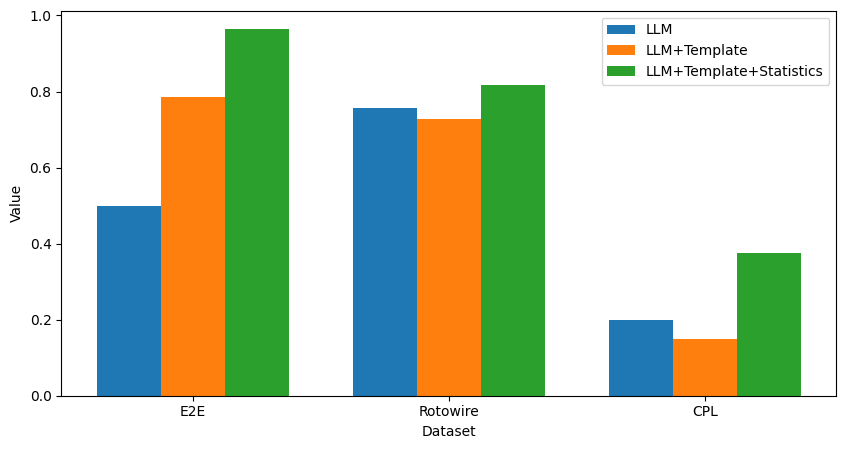

In [4]:
import matplotlib.pyplot as plt  
import numpy as np  
  
# 假设的3x3表格数据  
# 行代表主体，列代表属性  


data = np.array([  
    [3.5/7, 25.0/33, 8.0/40],  # 主体1的属性值  
    [5.5/7, 24.0/33, 6.0/40],  # 主体2的属性值  
    [6.75/7, 27.0/33, 15.0/40]   # 主体3的属性值  
])  
  
# 主体和属性的标签  
attributes  = ['E2E', 'Rotowire', 'CPL']  
subjects = ['LLM', 'LLM+Template', 'LLM+Template+Statistics']  
  
# 柱状图的宽度  
bar_width = 0.25  
  
# 设置x轴的位置（为了并排显示）  
index = np.arange(len(attributes))  
  
# 创建一个新的图形和轴对象  
fig, ax = plt.subplots(figsize=(10, 5))  
  
# 绘制柱状图，每个主体一组  
for i, (subject, subject_data) in enumerate(zip(subjects, data)):  
    # 计算当前主体的条形图的x位置  
    x_pos = index + i * bar_width  
    # 绘制条形图  
    ax.bar(x_pos, subject_data, bar_width, label=subject)  
  
# 设置x轴标签和刻度  
ax.set_xlabel('Dataset', fontsize=14)  
ax.set_xticks(index + bar_width)  # 将刻度放在条形的中心  
ax.set_xticklabels(attributes)  
  
# 设y轴标签  
ax.set_ylabel('Value', fontsize=14)  
  
# 添加图例  
ax.legend()  
plt.savefig('/home/jiangpeiwen2/jiangpeiwen2/text-kgs-table/components/mix_ie/llm/first_stage.pdf', dpi=600, bbox_inches='tight',format="pdf")
# 显示图形  
plt.show()